In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import re
import nltk
from nltk.util import ngrams
from wordcloud import WordCloud
import collections
import warnings
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
import tqdm
from operator import itemgetter
from pprint import pprint

warnings.simplefilter("ignore", DeprecationWarning)

In [2]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\manme\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\manme\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\manme\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\manme\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Loading the ACL & EMNLP papers
The Association for Computational Linguistics (ACL) is the international scientific and professional society for people working on problems involving natural language and computation. An annual meeting is held each summer in locations where significant computational linguistics research is carried out. It was founded in 1962, originally named the Association for Machine Translation and Computational Linguistics (AMTCL). It became the ACL in 1968. 

Empirical Methods in Natural Language Processing (EMNLP) is a leading conference in the area of natural language processing and artificial intelligence. Along with the Association for Computational Linguistics (ACL), it is one of the two primary high impact conferences for natural language processing research. EMNLP is organized by the ACL special interest group on linguistic data (SIGDAT) and was started in 1996, based on an earlier conference series called Workshop on Very Large Corpora (WVLC).

The dataset contains information on the various papers from both venues that were published from 2016 until 2021 (last 5 years). 

In [3]:
acl_df = pd.concat([pd.read_csv(f, sep=',') for f in glob.glob("../data/ACL/*.csv")],ignore_index=True)
acl_df['Conference'] = 'ACL'

emnlp_df = pd.concat([pd.read_csv(f, sep=',') for f in glob.glob("../data/EMNLP/*.csv")],ignore_index=True)
emnlp_df['Conference'] = 'EMNLP'

df = pd.concat([acl_df, emnlp_df])

In [4]:
df.columns

Index(['Paper Title', 'Authors', 'Abstract', 'Volume', 'Month', 'Year',
       'Address', 'Venues', 'Pages', 'URL', 'Publisher', 'Note', 'Language',
       'DOI', 'DOI link', 'PDF Link', 'GitHub Link', 'Video Link',
       'Conference'],
      dtype='object')

In [29]:
df.shape

(11929, 19)

### Plotting the number of research articles published each year
In order to understand how the natural language processing field has recently exploded in popularity, we will begin by visualizing the number of publications per year.

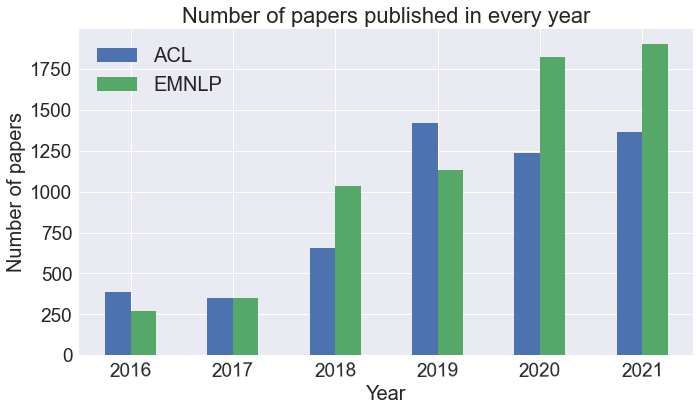

In [5]:
papers_by_year = df.groupby(['Year','Conference'])
paper_counts = papers_by_year.size().unstack(level=1)

paper_counts.plot(figsize=(11,6), kind='bar')
plt.xlabel('Year',fontdict={'fontsize':20})
plt.ylabel('Number of papers',fontdict={'fontsize':20})
plt.xticks(fontsize=19,rotation=1)
plt.yticks(fontsize=19)
plt.title('Number of papers published in every year',fontsize=22)
plt.legend(loc=2, prop={'size':20})
plt.savefig('../results/EDA/papers-per-yr.pdf', bbox_inches='tight')
plt.savefig('../results/EDA/papers-per-yr.png', bbox_inches='tight')
plt.show()

### Number of articles with GitHub Repositories

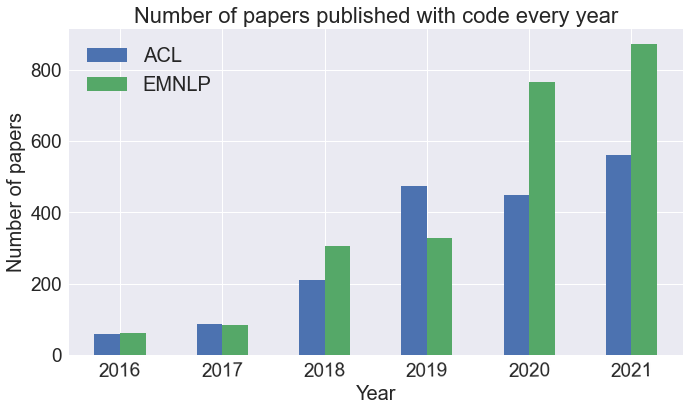

In [6]:
papers_with_code = df[df['GitHub Link'].notnull()].groupby(['Year','Conference']).size().unstack(level=1)

papers_with_code.plot(figsize=(11,6), kind='bar')
plt.xlabel('Year',fontdict={'fontsize':20})
plt.ylabel('Number of papers',fontdict={'fontsize':20})
plt.xticks(fontsize=19,rotation=1)
plt.yticks(fontsize=19)
plt.title('Number of papers published with code every year',fontsize=22)
plt.legend(loc=2, prop={'size':20})
plt.savefig('../results/EDA/papers-with-code-per-yr.pdf', bbox_inches='tight')
plt.savefig('../results/EDA/papers-with-code-per-yr.png', bbox_inches='tight')
plt.show()

### Number of articles with Video Links

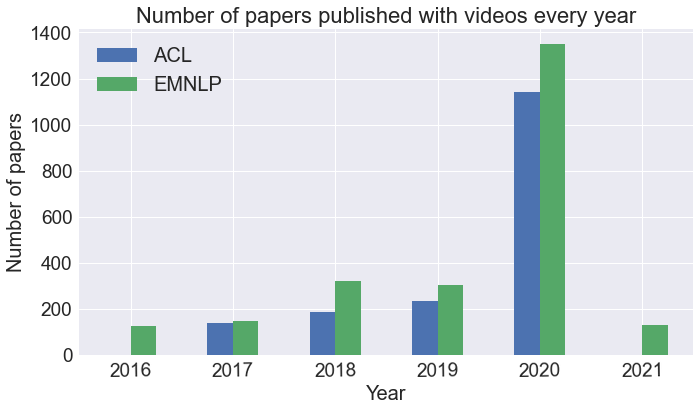

In [7]:
papers_with_video = df[df['Video Link'].notnull()].groupby(['Year','Conference']).size().unstack(level=1)

papers_with_video.plot(figsize=(11,6), kind='bar')
plt.xlabel('Year',fontdict={'fontsize':20})
plt.ylabel('Number of papers',fontdict={'fontsize':20})
plt.xticks(fontsize=19,rotation=1)
plt.yticks(fontsize=19)
plt.title('Number of papers published with videos every year',fontsize=22)
plt.legend(loc=2, prop={'size':20})
plt.savefig('../results/EDA/papers-with-video-per-yr.pdf', bbox_inches='tight')
plt.savefig('../results/EDA/papers-with-video-per-yr.png', bbox_inches='tight')
plt.show()

### Number of publication venues per year
*Refers to the number of different issues, conferences and workshops under the main publication venue*

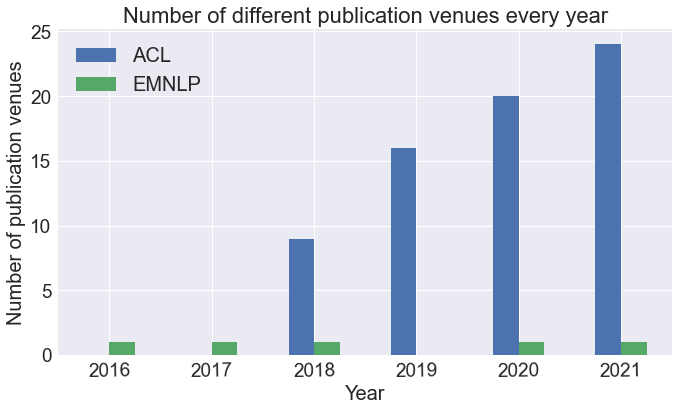

In [8]:
venues_per_yr = df[df['Venues'].notnull()].groupby(['Year','Conference']).agg(venues_per_yr=('Venues','nunique')).unstack(level=1)

venues_per_yr.plot(figsize=(11,6), kind='bar')
plt.xlabel('Year',fontdict={'fontsize':20})
plt.ylabel('Number of publication venues',fontdict={'fontsize':20})
plt.xticks(fontsize=19,rotation=1)
plt.yticks(fontsize=19)
plt.title('Number of different publication venues every year',fontsize=22)
legend = plt.legend(loc=2, prop={'size':20})
legend.get_texts()[0].set_text('ACL')
legend.get_texts()[1].set_text('EMNLP')
plt.savefig('../results/EDA/publication-venues-per-yr.pdf', bbox_inches='tight')
plt.savefig('../results/EDA/publication-venues-per-yr.png', bbox_inches='tight')
plt.show()

### Number of event venues per year

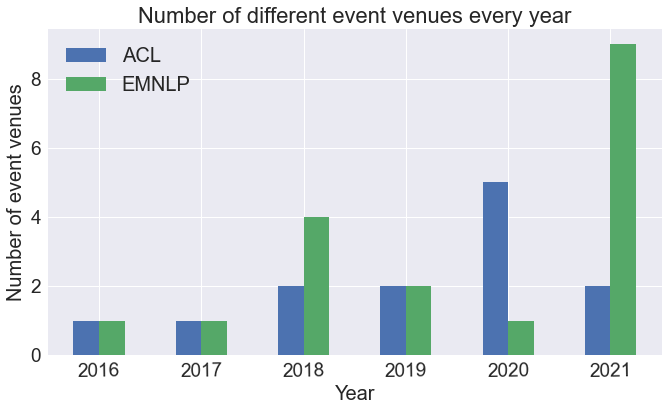

In [9]:
event_venues_per_yr = df[df['Address'].notnull()].groupby(['Year','Conference']).agg(venues_per_yr=('Address','nunique')).unstack(level=1)

event_venues_per_yr.plot(figsize=(11,6), kind='bar')
plt.xlabel('Year',fontdict={'fontsize':20})
plt.ylabel('Number of event venues',fontdict={'fontsize':20})
plt.xticks(fontsize=19,rotation=1)
plt.yticks(fontsize=19)
plt.title('Number of different event venues every year',fontsize=22)
legend = plt.legend(loc=2, prop={'size':20})
legend.get_texts()[0].set_text('ACL')
legend.get_texts()[1].set_text('EMNLP')
plt.savefig('../results/EDA/event-venues-per-yr.pdf', bbox_inches='tight')
plt.savefig('../results/EDA/event-venues-per-yr.png', bbox_inches='tight')
plt.show()

### WordCloud for Title

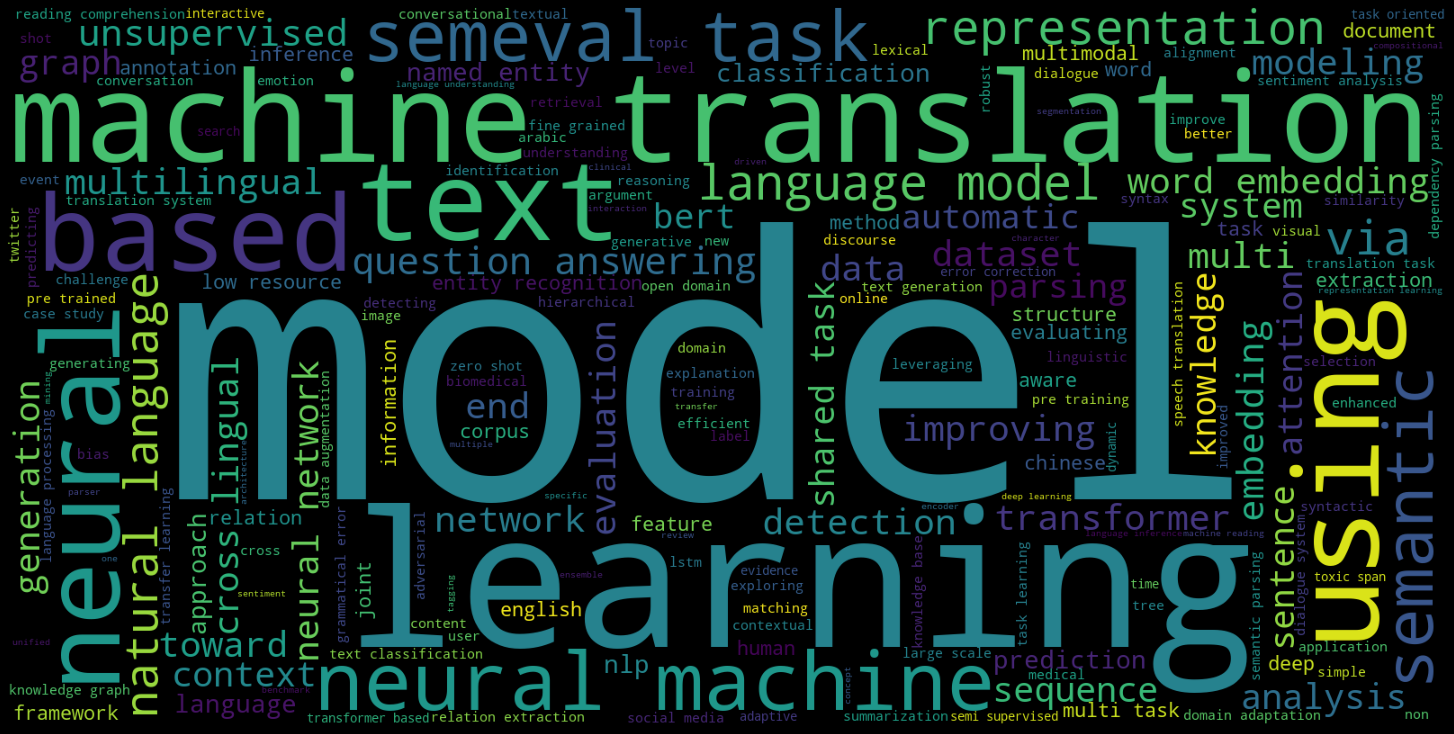

In [10]:
# For ACL
# Preprocess the Paper Title by removing symbols and converting the string to lowercase
acl_df['Paper Title'] = acl_df['Paper Title'].astype('str')
acl_df['title_preprocessed'] = acl_df['Paper Title'].map(lambda x:re.sub(r'[^\w\s]','', x))
acl_df['title_preprocessed'] = acl_df['Paper Title'].map(lambda x:x.lower())

# Concatenate all titles in one string
acl_all_titles = ' '.join(acl_df['title_preprocessed'])

# Tokenize and remove stopwords
acl_all_titles_tokenized = nltk.tokenize.word_tokenize(acl_all_titles)
en_stopwords = nltk.corpus.stopwords.words('english')
en_stopwords.extend(['for',':','and','of','a','in','with','the'])
acl_all_titles_clean = ' '.join([word for word in acl_all_titles_tokenized if not word in en_stopwords])

# Create wordcloud object & visualize
acl_wordcloud = WordCloud(width=1600,height=800).generate(acl_all_titles_clean)
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(acl_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('../results/EDA/acl-wordcloud.pdf', bbox_inches='tight')
plt.savefig('../results/EDA/acl-wordcloud.png', bbox_inches='tight')
plt.show()

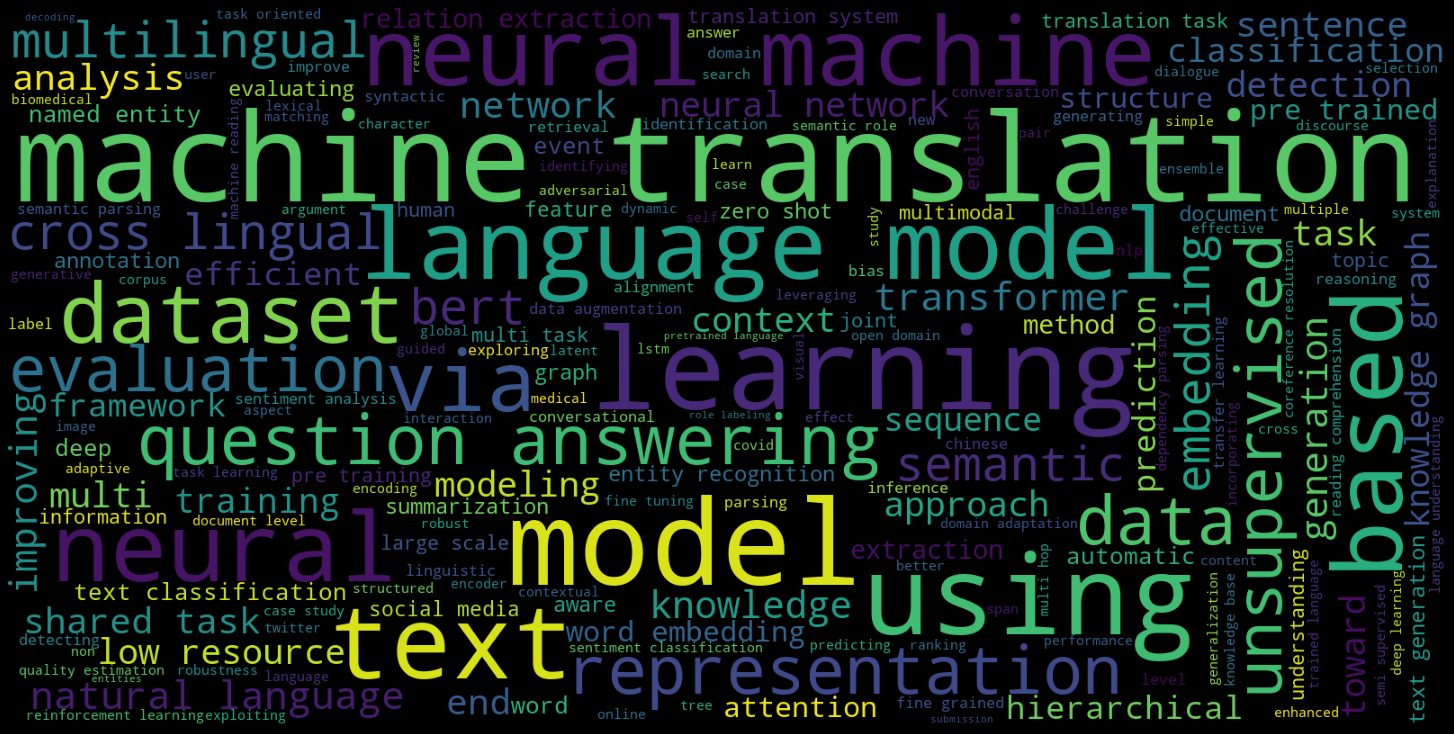

In [11]:
# For EMNLP
# Preprocess the Paper Title by removing symbols and converting the string to lowercase
emnlp_df['Paper Title'] = emnlp_df['Paper Title'].astype('str')
emnlp_df['title_preprocessed'] = emnlp_df['Paper Title'].map(lambda x:re.sub(r'[^\w\s]','', x))
emnlp_df['title_preprocessed'] = emnlp_df['Paper Title'].map(lambda x:x.lower())

# Concatenate all titles in one string
emnlp_all_titles = ' '.join(emnlp_df['title_preprocessed'])

# Tokenize and remove stopwords
emnlp_all_titles_tokenized = nltk.tokenize.word_tokenize(emnlp_all_titles)
emnlp_all_titles_clean = ' '.join([word for word in emnlp_all_titles_tokenized if not word in en_stopwords])

# Create wordcloud object & visualize
emnlp_wordcloud = WordCloud(width=1600,height=800).generate(emnlp_all_titles_clean)
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(emnlp_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('../results/EDA/emnlp-wordcloud.pdf', bbox_inches='tight')
plt.savefig('../results/EDA/emnlp-wordcloud.png', bbox_inches='tight')
plt.show()

### WordCloud for Abstract

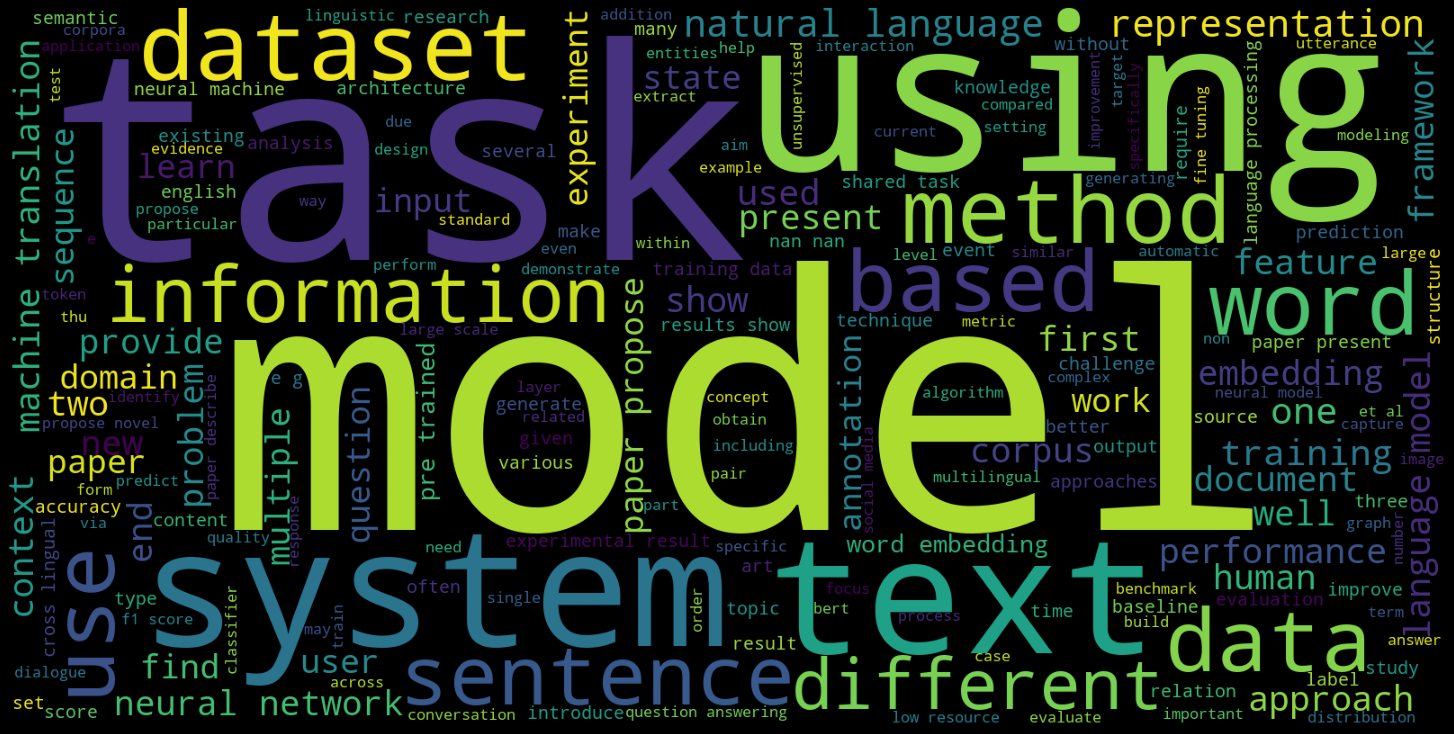

In [12]:
# For ACL
# Preprocess the Abstract by removing symbols and converting the string to lowercase
acl_df['Abstract'] = acl_df['Abstract'].astype('str')
acl_df['abstract_preprocessed'] = acl_df['Abstract'].map(lambda x:re.sub(r'[^\w\s]','', x))
acl_df['abstract_preprocessed'] = acl_df['Abstract'].map(lambda x:x.lower())

# Concatenate all Abstracts in one string
acl_all_abstracts = ' '.join(acl_df['abstract_preprocessed'])

# Tokenize and remove stopwords
acl_all_abstracts_tokenized = nltk.tokenize.word_tokenize(acl_all_abstracts)
acl_all_abstracts_clean = ' '.join([word for word in acl_all_abstracts_tokenized if not word in en_stopwords])

# Create wordcloud object & visualize
acl_wordcloud = WordCloud(width=1600,height=800).generate(acl_all_abstracts_clean)
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(acl_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('../results/EDA/acl-wordcloud-abs.pdf', bbox_inches='tight')
plt.savefig('../results/EDA/acl-wordcloud-abs.png', bbox_inches='tight')
plt.show()

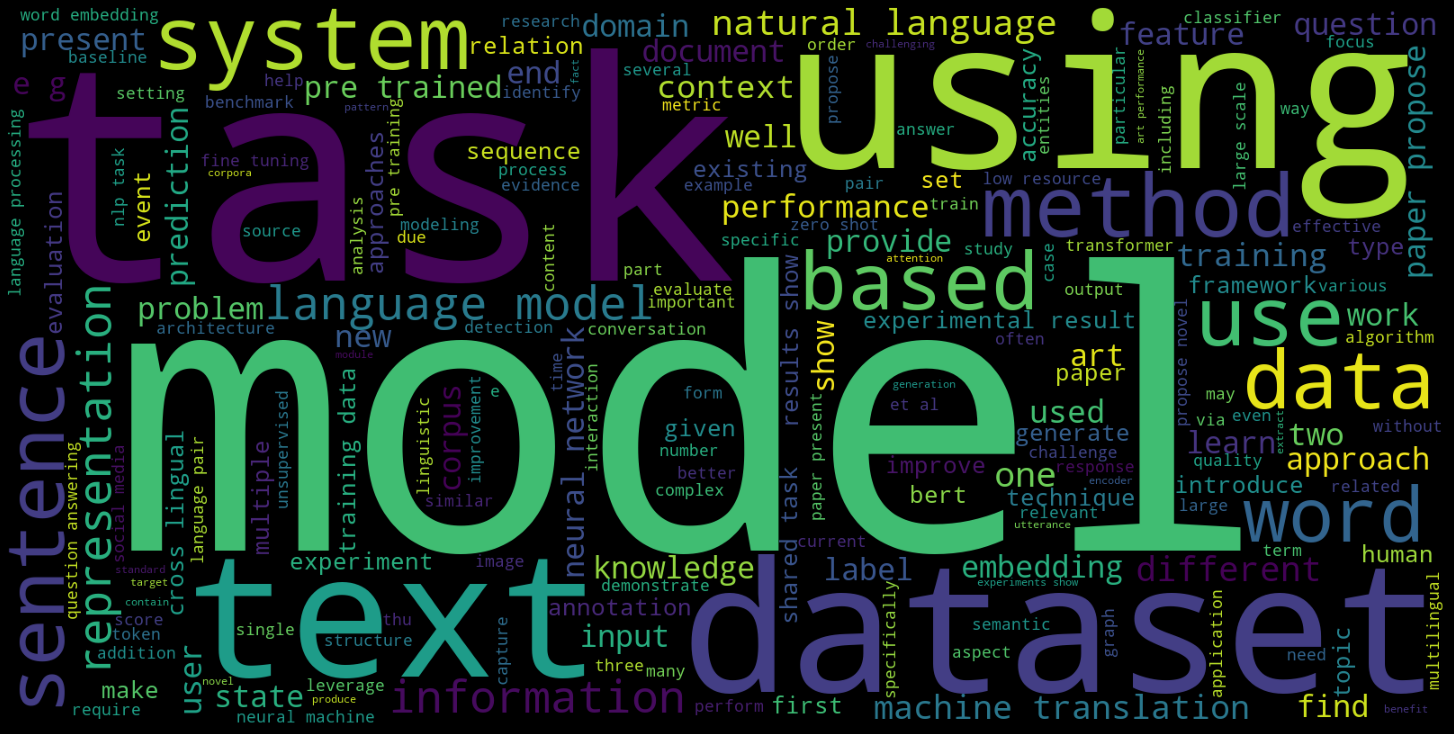

In [13]:
# For EMNLP
# Preprocess the Abstract by removing symbols and converting the string to lowercase
emnlp_df['Abstract'] = emnlp_df['Abstract'].astype('str')
emnlp_df['abstract_preprocessed'] = emnlp_df['Abstract'].map(lambda x:re.sub(r'[^\w\s]','', x))
emnlp_df['abstract_preprocessed'] = emnlp_df['Abstract'].map(lambda x:x.lower())

# Concatenate all Abstracts in one string
emnlp_all_abstracts = ' '.join(emnlp_df['abstract_preprocessed'])

# Tokenize and remove stopwords
emnlp_all_abstracts_tokenized = nltk.tokenize.word_tokenize(emnlp_all_abstracts)
emnlp_all_abstracts_clean = ' '.join([word for word in emnlp_all_abstracts_tokenized if not word in en_stopwords])

# Create wordcloud object & visualize
emnlp_wordcloud = WordCloud(width=1600,height=800).generate(emnlp_all_abstracts_clean)
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(emnlp_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('../results/EDA/emnlp-wordcloud-abs.pdf', bbox_inches='tight')
plt.savefig('../results/EDA/emnlp-wordcloud-abs.png', bbox_inches='tight')
plt.show()

### Top-10 unigrams, bigrams, and trigrams for Paper Title 

### For ACL

In [14]:
acl_all_titles_clean_tokenized = nltk.word_tokenize(acl_all_titles_clean)
acl_unigrams_overall = ngrams(acl_all_titles_clean_tokenized, 1)
acl_bigrams_overall = ngrams(acl_all_titles_clean_tokenized, 2)
acl_trigrams_overall = ngrams(acl_all_titles_clean_tokenized, 3)

acl_unigrams_overall_count = collections.Counter(acl_unigrams_overall)
acl_bigrams_overall_count = collections.Counter(acl_bigrams_overall)
acl_trigrams_overall_count = collections.Counter(acl_trigrams_overall)

acl_unigrams_overall_df = pd.DataFrame(acl_unigrams_overall_count.most_common(10), columns=['Unigram','Count'])
acl_bigrams_overall_df = pd.DataFrame(acl_bigrams_overall_count.most_common(10), columns=['Bigram','Count'])
acl_trigrams_overall_df = pd.DataFrame(acl_trigrams_overall_count.most_common(10), columns=['Trigram','Count'])

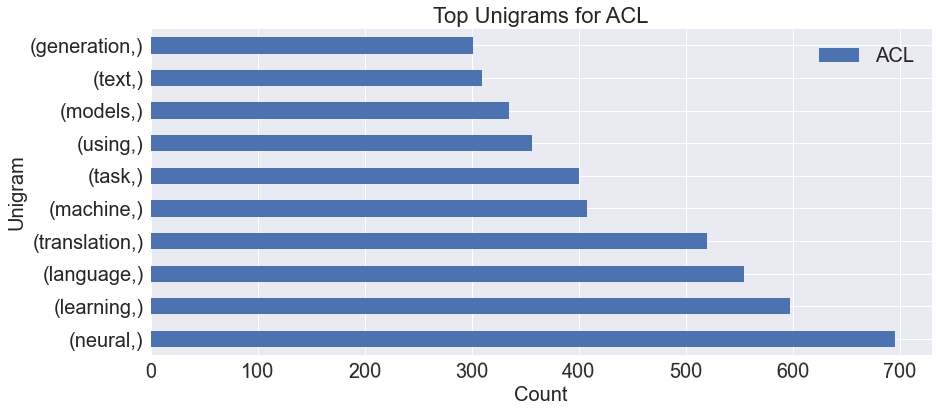

In [15]:
# Plot unigrams
acl_unigrams_overall_df.plot('Unigram','Count', figsize=(14,6), kind='barh')
plt.title('Top Unigrams for ACL', fontsize=22)
plt.xlabel('Count',fontdict={'fontsize':20})
plt.ylabel('Unigram',fontdict={'fontsize':20})
plt.xticks(fontsize=20,rotation=1)
plt.yticks(fontsize=20)
legend = plt.legend(prop={'size':20})
legend.get_texts()[0].set_text('ACL')
plt.savefig('../results/EDA/overall-unigrams-acl.pdf', bbox_inches='tight')
plt.savefig('../results/EDA/overall-unigrams-acl.png', bbox_inches='tight')
plt.show()

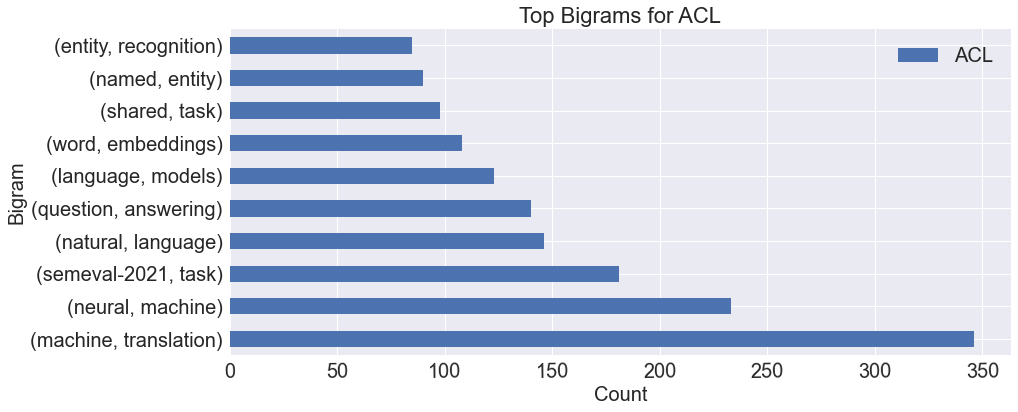

In [16]:
# Plot bigrams
acl_bigrams_overall_df.plot('Bigram','Count', figsize=(14,6), kind='barh')
plt.title('Top Bigrams for ACL', fontsize=22)
plt.xlabel('Count',fontdict={'fontsize':20})
plt.ylabel('Bigram',fontdict={'fontsize':20})
plt.xticks(fontsize=20,rotation=1)
plt.yticks(fontsize=20)
legend = plt.legend(prop={'size':20})
legend.get_texts()[0].set_text('ACL')
plt.savefig('../results/EDA/overall-bigrams-acl.pdf', bbox_inches='tight')
plt.savefig('../results/EDA/overall-bigrams-acl.png', bbox_inches='tight')
plt.show()

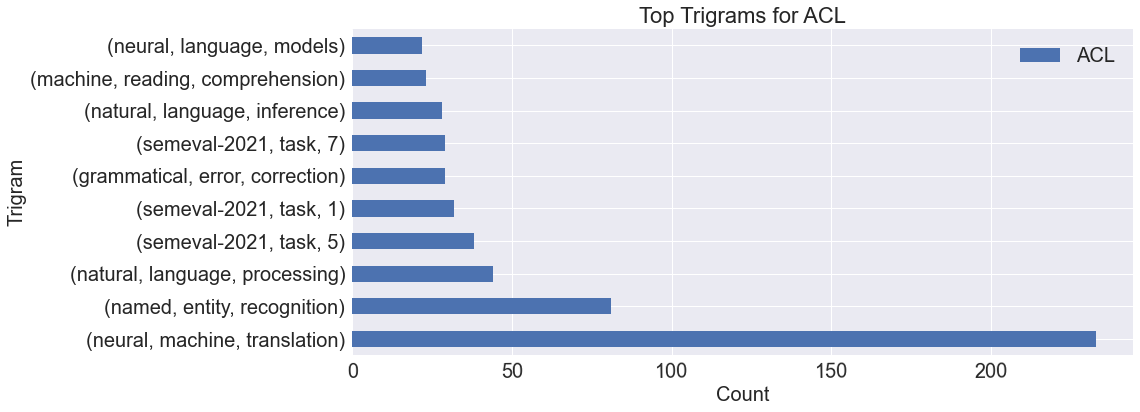

In [17]:
# Plot trigrams
acl_trigrams_overall_df.plot('Trigram','Count', figsize=(14,6), kind='barh')
plt.title('Top Trigrams for ACL', fontsize=22)
plt.xlabel('Count',fontdict={'fontsize':20})
plt.ylabel('Trigram',fontdict={'fontsize':20})
plt.xticks(fontsize=20,rotation=1)
plt.yticks(fontsize=20)
legend = plt.legend(prop={'size':20})
legend.get_texts()[0].set_text('ACL')
plt.savefig('../results/EDA/overall-trigrams-acl.pdf', bbox_inches='tight')
plt.savefig('../results/EDA/overall-trigrams-acl.png', bbox_inches='tight')
plt.show()

### For EMNLP

In [18]:
emnlp_all_titles_clean_tokenized = nltk.word_tokenize(emnlp_all_titles_clean)
emnlp_unigrams_overall = ngrams(emnlp_all_titles_clean_tokenized, 1)
emnlp_bigrams_overall = ngrams(emnlp_all_titles_clean_tokenized, 2)
emnlp_trigrams_overall = ngrams(emnlp_all_titles_clean_tokenized, 3)

emnlp_unigrams_overall_count = collections.Counter(emnlp_unigrams_overall)
emnlp_bigrams_overall_count = collections.Counter(emnlp_bigrams_overall)
emnlp_trigrams_overall_count = collections.Counter(emnlp_trigrams_overall)

emnlp_unigrams_overall_df = pd.DataFrame(emnlp_unigrams_overall_count.most_common(10), columns=['Unigram','Count'])
emnlp_bigrams_overall_df = pd.DataFrame(emnlp_bigrams_overall_count.most_common(10), columns=['Bigram','Count'])
emnlp_trigrams_overall_df = pd.DataFrame(emnlp_trigrams_overall_count.most_common(10), columns=['Trigram','Count'])

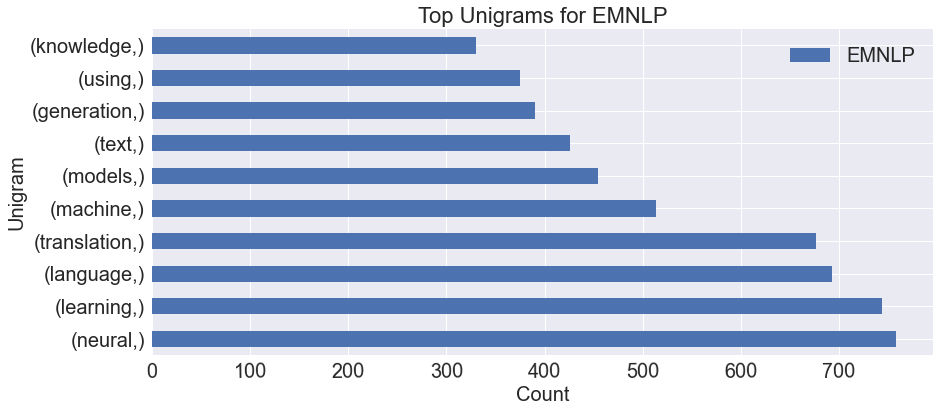

In [19]:
# Plot unigrams
emnlp_unigrams_overall_df.plot('Unigram','Count', figsize=(14,6), kind='barh')
plt.title('Top Unigrams for EMNLP', fontsize=22)
plt.xlabel('Count',fontdict={'fontsize':20})
plt.ylabel('Unigram',fontdict={'fontsize':20})
plt.xticks(fontsize=20,rotation=1)
plt.yticks(fontsize=20)
legend = plt.legend(prop={'size':20})
legend.get_texts()[0].set_text('EMNLP')
plt.savefig('../results/EDA/overall-unigrams-emnlp.pdf', bbox_inches='tight')
plt.savefig('../results/EDA/overall-unigrams-emnlp.png', bbox_inches='tight')
plt.show()

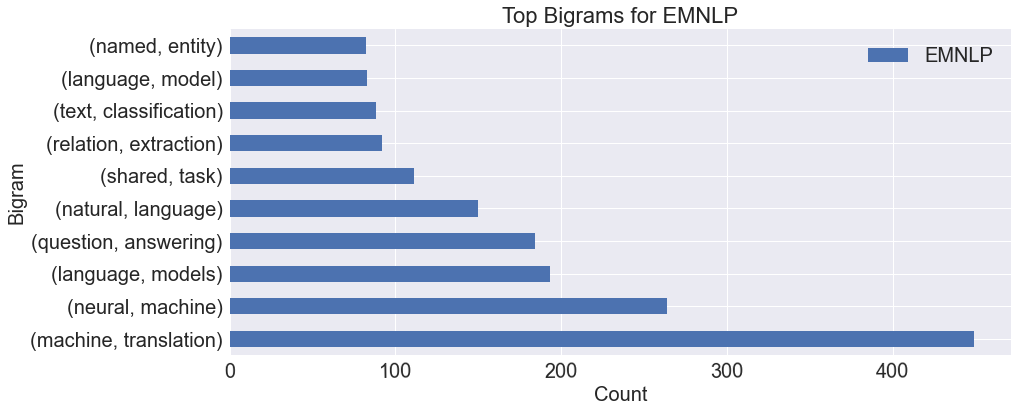

In [20]:
# Plot bigrams
emnlp_bigrams_overall_df.plot('Bigram','Count', figsize=(14,6), kind='barh')
plt.title('Top Bigrams for EMNLP', fontsize=22)
plt.xlabel('Count',fontdict={'fontsize':20})
plt.ylabel('Bigram',fontdict={'fontsize':20})
plt.xticks(fontsize=20,rotation=1)
plt.yticks(fontsize=20)
legend = plt.legend(prop={'size':20})
legend.get_texts()[0].set_text('EMNLP')
plt.savefig('../results/EDA/overall-bigrams-emnlp.pdf', bbox_inches='tight')
plt.savefig('../results/EDA/overall-bigrams-emnlp.png', bbox_inches='tight')
plt.show()

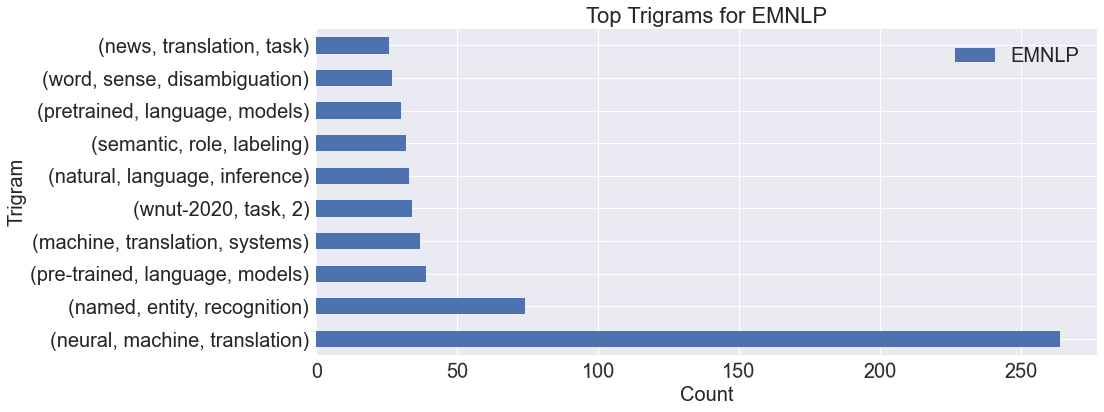

In [21]:
# Plot trigrams
emnlp_trigrams_overall_df.plot('Trigram','Count', figsize=(14,6), kind='barh')
plt.title('Top Trigrams for EMNLP', fontsize=22)
plt.xlabel('Count',fontdict={'fontsize':20})
plt.ylabel('Trigram',fontdict={'fontsize':20})
plt.xticks(fontsize=20,rotation=1)
plt.yticks(fontsize=20)
legend = plt.legend(prop={'size':20})
legend.get_texts()[0].set_text('EMNLP')
plt.savefig('../results/EDA/overall-trigrams-emnlp.pdf', bbox_inches='tight')
plt.savefig('../results/EDA/overall-trigrams-emnlp.png', bbox_inches='tight')
plt.show()

### Topic Modelling

In [22]:
def preprocess_text(sentence):
    # Lowercase
    sentence = sentence.lower()
    
    # Remove all non-alphabets (punctuation, numbers, new-line characters and extra-spaces)
    sentence = re.sub(r'[^a-zA-Z]+', ' ', sentence)
    sentence = sentence.replace('\n', '')
    # Remove URLs
    sentence = re.sub(r'https\S+', '', sentence)
    # Remove double spacing
    sentence = re.sub('\s+', ' ', sentence)
    
    # Tokenize & remove stop-words
    word_list = nltk.word_tokenize(sentence)    
    stopwords_list = nltk.corpus.stopwords.words('english')
    word_list = [word for word in word_list if word not in stopwords_list]
    
    # Remove very small words, length < 3, they don't contribute any useful information
    word_list = [word for word in word_list if len(word) > 3]
        
    sentence = ' '.join(word_list)
    
    return sentence

In [23]:
# Constants for topic models
EPOCHS = 205
TOPICS = 5
CHUNK_SIZE = 1000
WORKERS = 7
EVAL_PERIOD = 10
ALPHA = 0.01
BETA = 0.9

In [24]:
# Pre-process the dataset for topic modelling
tqdm.tqdm.pandas()
acl_df['title_tokenized'] = acl_df['Paper Title'].progress_apply(lambda x:preprocess_text(str(x)))
emnlp_df['title_tokenized'] = emnlp_df['Paper Title'].progress_apply(lambda x:preprocess_text(str(x)))

tqdm.tqdm.pandas()
acl_df['abstract_tokenized'] = acl_df['Abstract'].progress_apply(lambda x:preprocess_text(str(x)))
emnlp_df['abstract_tokenized'] = emnlp_df['Abstract'].progress_apply(lambda x:preprocess_text(str(x)))

100%|██████████| 6514/6514 [00:04<00:00, 1423.20it/s]


### Generate TF-IDF Embeddings and extract topics using Parallel LDA from:
1. Paper Titles 

In [25]:
# For ACL 
acl_titles = acl_df['title_tokenized'].str.split()
acl_title_dictionary = gensim.corpora.Dictionary(acl_titles)
acl_title_dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=20000)

acl_title_tfidf_model = gensim.models.TfidfModel(dictionary=acl_title_dictionary)

acl_title_corpus = [acl_title_dictionary.doc2bow(d) for d in acl_titles]
acl_title_corpus_tfidf = list(acl_title_tfidf_model[acl_title_corpus])

gensim_plda = gensim.models.ldamulticore.LdaMulticore(corpus=acl_title_corpus_tfidf, num_topics=TOPICS, id2word=acl_title_dictionary, chunksize=CHUNK_SIZE, workers=WORKERS, passes=EPOCHS, 
                                                     eval_every = EVAL_PERIOD, per_word_topics=True, random_state=1, alpha=ALPHA, eta=BETA)
acl_title_topics = gensim_plda.print_topics()
print('Topics:')
print(acl_title_topics)

Topics:
[(0, '0.012*"detection" + 0.012*"entity" + 0.010*"extraction" + 0.009*"attention" + 0.009*"recognition" + 0.009*"classification" + 0.009*"relation" + 0.008*"knowledge" + 0.008*"networks" + 0.008*"named"'), (1, '0.016*"parsing" + 0.011*"semantic" + 0.009*"dependency" + 0.008*"sequence" + 0.007*"semeval" + 0.007*"task" + 0.007*"neural" + 0.007*"lexical" + 0.007*"error" + 0.007*"models"'), (2, '0.026*"translation" + 0.020*"machine" + 0.017*"neural" + 0.010*"word" + 0.010*"domain" + 0.010*"learning" + 0.008*"unsupervised" + 0.008*"summarization" + 0.008*"speech" + 0.008*"multi"'), (3, '0.017*"language" + 0.014*"natural" + 0.011*"task" + 0.008*"generation" + 0.007*"shared" + 0.007*"models" + 0.007*"processing" + 0.007*"news" + 0.006*"corpus" + 0.006*"learning"'), (4, '0.010*"cross" + 0.009*"learning" + 0.009*"lingual" + 0.008*"reading" + 0.008*"comprehension" + 0.006*"transfer" + 0.006*"text" + 0.006*"data" + 0.006*"gender" + 0.006*"language"')]


In [26]:
# For EMNLP
emnlp_titles = emnlp_df['title_tokenized'].str.split()
emnlp_title_dictionary = gensim.corpora.Dictionary(emnlp_titles)
emnlp_title_dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=20000)

emnlp_title_tfidf_model = gensim.models.TfidfModel(dictionary=emnlp_title_dictionary)

emnlp_title_corpus = [emnlp_title_dictionary.doc2bow(d) for d in emnlp_titles]
emnlp_title_corpus_tfidf = list(emnlp_title_tfidf_model[emnlp_title_corpus])

emnlp_title_gensim_plda = gensim.models.ldamulticore.LdaMulticore(corpus=emnlp_title_corpus_tfidf, num_topics=TOPICS, id2word=emnlp_title_dictionary, chunksize=CHUNK_SIZE, workers=WORKERS, passes=EPOCHS, 
                                                     eval_every = EVAL_PERIOD, per_word_topics=True, random_state=1, alpha=ALPHA, eta=BETA)
emnlp_title_topics = emnlp_title_gensim_plda.print_topics()
print('Topics:')
print(emnlp_title_topics)

Topics:
[(0, '0.021*"language" + 0.012*"natural" + 0.012*"models" + 0.007*"inference" + 0.007*"reasoning" + 0.007*"knowledge" + 0.006*"commonsense" + 0.006*"understanding" + 0.006*"generation" + 0.005*"trained"'), (1, '0.014*"summarization" + 0.010*"recognition" + 0.009*"entity" + 0.009*"named" + 0.009*"text" + 0.008*"neural" + 0.007*"abstractive" + 0.007*"models" + 0.005*"transformer" + 0.005*"document"'), (2, '0.011*"learning" + 0.010*"semantic" + 0.010*"parsing" + 0.010*"extraction" + 0.009*"classification" + 0.009*"text" + 0.008*"relation" + 0.008*"graph" + 0.008*"based" + 0.008*"networks"'), (3, '0.029*"translation" + 0.023*"machine" + 0.015*"neural" + 0.015*"task" + 0.012*"question" + 0.009*"answering" + 0.009*"system" + 0.009*"systems" + 0.008*"domain" + 0.008*"shared"'), (4, '0.009*"word" + 0.008*"social" + 0.008*"detection" + 0.008*"media" + 0.008*"covid" + 0.007*"bert" + 0.007*"using" + 0.007*"learning" + 0.006*"bias" + 0.006*"detecting"')]


2. Abstract

In [27]:
# For ACL 
acl_abstracts = acl_df['abstract_tokenized'].str.split()
acl_abstract_dictionary = gensim.corpora.Dictionary(acl_abstracts)
acl_abstract_dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=20000)

acl_abstract_tfidf_model = gensim.models.TfidfModel(dictionary=acl_abstract_dictionary)

acl_abstract_corpus = [acl_abstract_dictionary.doc2bow(d) for d in acl_abstracts]
acl_abstract_corpus_tfidf = list(acl_abstract_tfidf_model[acl_abstract_corpus])

acl_abstract_gensim_plda = gensim.models.ldamulticore.LdaMulticore(corpus=acl_abstract_corpus_tfidf, num_topics=TOPICS, id2word=acl_abstract_dictionary, chunksize=CHUNK_SIZE, workers=WORKERS, passes=EPOCHS, 
                                                     eval_every = EVAL_PERIOD, per_word_topics=True, random_state=1, alpha=ALPHA, eta=BETA)
acl_abstract_topics = acl_abstract_gensim_plda.print_topics()
print('Topics:')
print(acl_abstract_topics)

Topics:
[(0, '0.000*"poetry" + 0.000*"poetic" + 0.000*"distinguishing" + 0.000*"insufficient" + 0.000*"proving" + 0.000*"mechanical" + 0.000*"lesser" + 0.000*"reproduction" + 0.000*"proliferation" + 0.000*"witnessed"'), (1, '0.002*"social" + 0.001*"media" + 0.001*"twitter" + 0.001*"news" + 0.001*"users" + 0.001*"sarcasm" + 0.001*"political" + 0.001*"user" + 0.001*"tweets" + 0.001*"online"'), (2, '0.000*"tone" + 0.000*"transducers" + 0.000*"finite" + 0.000*"reduplication" + 0.000*"syllable" + 0.000*"full" + 0.000*"morpho" + 0.000*"phonotactic" + 0.000*"state" + 0.000*"manage"'), (3, '0.000*"subregular" + 0.000*"stress" + 0.000*"tier" + 0.000*"default" + 0.000*"strictly" + 0.000*"uniformly" + 0.000*"argued" + 0.000*"unbounded" + 0.000*"favor" + 0.000*"motivate"'), (4, '0.003*"translation" + 0.003*"model" + 0.003*"task" + 0.003*"models" + 0.003*"language" + 0.003*"data" + 0.003*"word" + 0.002*"text" + 0.002*"training" + 0.002*"learning"')]


In [28]:
# For EMNLP
emnlp_abstracts = emnlp_df['abstract_tokenized'].str.split()
emnlp_abstract_dictionary = gensim.corpora.Dictionary(emnlp_abstracts)
emnlp_abstract_dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=20000)

emnlp_abstract_tfidf_model = gensim.models.TfidfModel(dictionary=emnlp_abstract_dictionary)

emnlp_abstract_corpus = [emnlp_abstract_dictionary.doc2bow(d) for d in emnlp_abstracts]
emnlp_abstract_corpus_tfidf = list(emnlp_abstract_tfidf_model[emnlp_abstract_corpus])

emnlp_abstract_gensim_plda = gensim.models.ldamulticore.LdaMulticore(corpus=emnlp_abstract_corpus_tfidf, num_topics=TOPICS, id2word=emnlp_abstract_dictionary, chunksize=CHUNK_SIZE, workers=WORKERS, passes=EPOCHS, 
                                                     eval_every = EVAL_PERIOD, per_word_topics=True, random_state=1, alpha=ALPHA, eta=BETA)
emnlp_abstract_topics = emnlp_abstract_gensim_plda.print_topics()
print('Topics:')
print(emnlp_abstract_topics)

Topics:
[(0, '0.003*"translation" + 0.003*"data" + 0.003*"language" + 0.002*"models" + 0.002*"task" + 0.002*"text" + 0.002*"training" + 0.002*"word" + 0.002*"knowledge" + 0.002*"learning"'), (1, '0.000*"poisoning" + 0.000*"poisoned" + 0.000*"backdoor" + 0.000*"clients" + 0.000*"attack" + 0.000*"attacks" + 0.000*"client" + 0.000*"victim" + 0.000*"sketch" + 0.000*"vulnerability"'), (2, '0.000*"develops" + 0.000*"theory" + 0.000*"optimality" + 0.000*"convex" + 0.000*"phonological" + 0.000*"algorithmic" + 0.000*"orders" + 0.000*"geometry" + 0.000*"homogeneous" + 0.000*"augmenting"'), (3, '0.000*"look" + 0.000*"extreme" + 0.000*"homogeneous" + 0.000*"augmenting" + 0.000*"readily" + 0.000*"polarities" + 0.000*"eventually" + 0.000*"contrasting" + 0.000*"recommending" + 0.000*"modification"'), (4, '0.000*"translation" + 0.000*"hindi" + 0.000*"marathi" + 0.000*"afrl" + 0.000*"laboratory" + 0.000*"english" + 0.000*"tamil" + 0.000*"force" + 0.000*"describes" + 0.000*"campaign"')]
